## Tutorial for using SMOPCA on Spatial-CITE-seq Mouse Thymus1 dataset
Import modules.

In [5]:
import logging
import h5py
import numpy as np
import pandas as pd
import scanpy as sc
import warnings
from SMOPCA.utils import preprocess_adata
from SMOPCA.model import SMOPCA
from sklearn.cluster import KMeans

for handler in logging.root.handlers[:]:  # avoid DEBUG level information in jupyter notebook
    logging.root.removeHandler(handler)
logging.basicConfig(level=logging.INFO)  # use DEBUG for verbose information
warnings.filterwarnings('ignore')


Load and check dataset.

In [6]:
adata1 = sc.read_h5ad(f'./data/Mouse_Thymus1_adata_RNA.h5ad')
adata2 = sc.read_h5ad(f'./data/Mouse_Thymus1_adata_ADT.h5ad')
X1, X2, pos = preprocess_adata([adata1, adata2])
print(X1.shape, X2.shape, pos.shape)

(4510, 2000) (4510, 51) (4510, 2)


Build the SMOPCA model and inference parameters.

In [7]:
smopca = SMOPCA(Y_list=[X1.T, X2.T], Z_dim=20, pos=pos, intercept=False)
smopca.estimateParams(sigma_init_list=(1, 1), tol_sigma=2e-5, sigma_xtol_list=(1e-6, 1e-6), gamma_init=5, estimate_gamma=True, gamma_tol=1)
z = smopca.calculatePosterior()
y_pred = KMeans(n_clusters=8, n_init=100).fit_predict(z)

INFO:src.SMOPCA:SMOPCA object created, with 4510 cells and [2000, 51] features and matern kernel
INFO:src.SMOPCA:start estimating parameters, this will take a while...
INFO:src.SMOPCA:calculating matern kernel, nu = 1.5, length_scale = 5
INFO:src.SMOPCA:estimating sigma1
INFO:src.SMOPCA:sigma1 using bound: (0.90000, 1.00000)
INFO:src.SMOPCA:iter 0 sigma1 brentq done, sigma1sqr = 1.00000, sigma1hatsqr = 0.96110
INFO:src.SMOPCA:iter 1 sigma1 brentq done, sigma1sqr = 0.96110, sigma1hatsqr = 0.96110
INFO:src.SMOPCA:reach tolerance threshold, sigma1 done!
INFO:src.SMOPCA:estimating sigma2
INFO:src.SMOPCA:sigma2 using bound: (0.60000, 0.70000)
INFO:src.SMOPCA:iter 0 sigma2 brentq done, sigma2sqr = 1.00000, sigma2hatsqr = 0.68715
INFO:src.SMOPCA:iter 1 sigma2 brentq done, sigma2sqr = 0.68715, sigma2hatsqr = 0.68715
INFO:src.SMOPCA:reach tolerance threshold, sigma2 done!
INFO:src.SMOPCA:iter 0 gamma minimize done, gamma = 5.00000, gamma_hat = 9.44829
INFO:src.SMOPCA:calculating matern kernel, 

Visualize the inferred spatial domain.

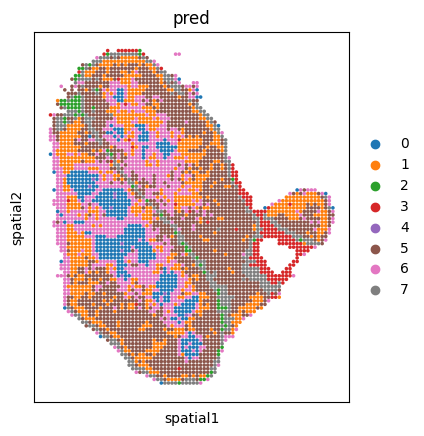

In [21]:
adata_res = sc.AnnData(z)
adata_res.obsm['spatial'] = pos
adata_res.obs['pred'] = pd.Categorical(y_pred)
sc.pl.spatial(adata_res, color='pred', spot_size=100)

Visualize the latent space using UMAP.

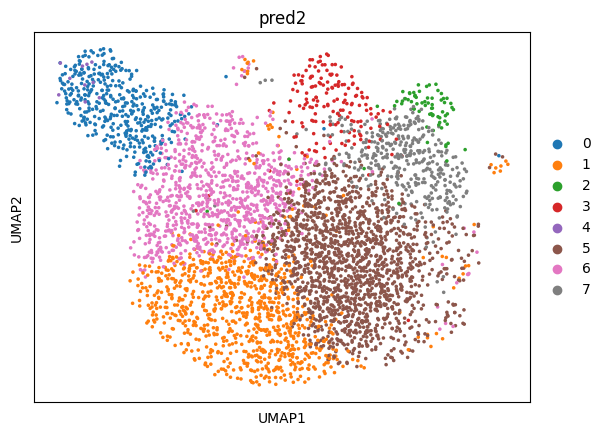

In [22]:
sc.pp.neighbors(adata_res, n_neighbors=100, use_rep='X', metric='euclidean')
sc.tl.umap(adata_res, min_dist=1)
sc.pl.umap(adata_res, color='pred1')

## Perform DIfferential Expression Analysis with SMOPCA Predicted labels
Find marker gene for each cluster using FindMarkers.

In [ ]:
library(rhdf5)
library(dplyr)
library(Seurat)
library(Matrix)
library(patchwork)
library(pheatmap)
h5_file <- H5Fopen(paste0("./data/Mouse_Thymus1_filtered.h5"))
cell <- as.matrix(h5_file$cells)  
gene <- as.matrix(h5_file$genes)
X <- as(h5_file$X1, "sparseMatrix")
h5closeAll()
rownames(X) <- gene
colnames(X) <- cell
y_pred <- as.matrix(read.csv("./data/smopca.csv", row.names=1))


seu <- CreateSeuratObject(counts = X, project = "diff_expr", min.cells = 0, min.features = 0)
seu <- NormalizeData(seu, normalization.method = "LogNormalize", scale.factor = 10000)
Idents(seu) <- y_pred

y_unique <- c('0', '1', '2', '3', '4', '5','6', '7')

res_folder <- "./res/" 
for (g in y_unique) {
  de.markers <- FindMarkers(seu, ident.1 = g, ident.2 = NULL, only.pos = F)
  write.csv(de.markers, file=paste0("./res/cluster_", g, "_marker.csv"))
  rm(de.markers)  
}

Select marker genes and perpare expression data for visualization.

In [1]:
import h5py
import numpy as np
import pandas as pd

top_gene_num = 10  # top gene num of each cluster
cluster_list = [0, 1, 2, 3, 4, 5, 6, 7]
de_csv_list = []
cluster_gene_dict = {}
top_gene_list = []
all_top_gene_list = []

y_pred = pd.read_csv("./data/smopca_pred_label.csv", index_col=0).values.flatten()
normed_df = pd.read_csv(f"./data/normed_gene_mat.csv", index_col=0)  # plotting needs normalized raw data
print("checking raw data shape:", normed_df.shape, y_pred.shape) 

# find markers for each cluster
for i in cluster_list:
    de_csv_i = pd.read_csv(f"./res/cluster_{i}_marker.csv", index_col=0)  # print this to see the sorted p values and genes
    de_csv_list.append(de_csv_i)
    count = j = 0  # j for the current gene index
    while count < top_gene_num:
        if de_csv_i.index[j] in top_gene_list:
            # print(f"gene {de_csv_i.index[j]} already exist in {top_gene_list}, continue")
            j += 1
            continue
        if de_csv_i['p_val_adj'].iloc[j] > 0.05:
            # print(f"gene {de_csv_i.index[j]} p_val > 0.05, stop finding")
            break
        top_gene_list.append(de_csv_i.index[j])
        count += 1
        j += 1

# find the subset expr matrix of interest
data_list = []
for top_gene in top_gene_list:
    expr_cluster_list = []
    expr_dat = np.array(normed_df.loc[top_gene])
    for i in cluster_list:
        expr_cluster = expr_dat[y_pred == i]
        expr_cluster_list.append(np.mean(expr_cluster))
    data_list.append(expr_cluster_list)
data_mat = np.array(data_list)
data_df = pd.DataFrame(data=data_mat, index=top_gene_list, columns=[f'cluster_{i}' for i in cluster_list])

# change gene and protein names for plotting
new_ind = []
for gene_name in data_df.index:
    if gene_name.count('.') == 0:
        new_ind.append(gene_name)
    else:
        new_gene_name = gene_name.replace('.', '-')
        new_ind.append(new_gene_name)
data_df.index = new_ind
print(data_df)
data_df.to_csv(f"./res/gene_dat_top={top_gene_num}.csv")


        cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  \
Fscn1    1.509689  -0.190807  -0.170747  -0.054342   3.763929  -0.190629   
Fcgbp    1.507249  -0.184203   0.053794  -0.155765   3.162336  -0.193747   
Krt5     1.557102  -0.214685   0.028330  -0.245042   2.554560  -0.221457   
Csn2     1.407385  -0.157235  -0.168600  -0.124694   1.506627  -0.163672   
H2-K1    1.847088  -0.360810   0.197649  -0.214400   2.226267  -0.370663   
...           ...        ...        ...        ...        ...        ...   
Pltp    -0.163044  -0.195512   0.808299   0.215301  -0.406531  -0.012424   
Ctsl     0.009056  -0.312814   0.362234  -0.263134  -0.599020  -0.000162   
Snhg11  -0.085105  -0.148682   0.361068   0.057533  -0.224066  -0.060387   
Hspa8    0.291912  -0.323534   0.890426   0.264068   1.083691  -0.030682   
Thy1    -0.601384  -0.004899   0.501562  -0.293479  -0.481433   0.081260   

        cluster_6  cluster_7  
Fscn1   -0.120785  -0.111927  
Fcgbp   -0.099330  -0.147

Visualize the marker genes with heatmap.

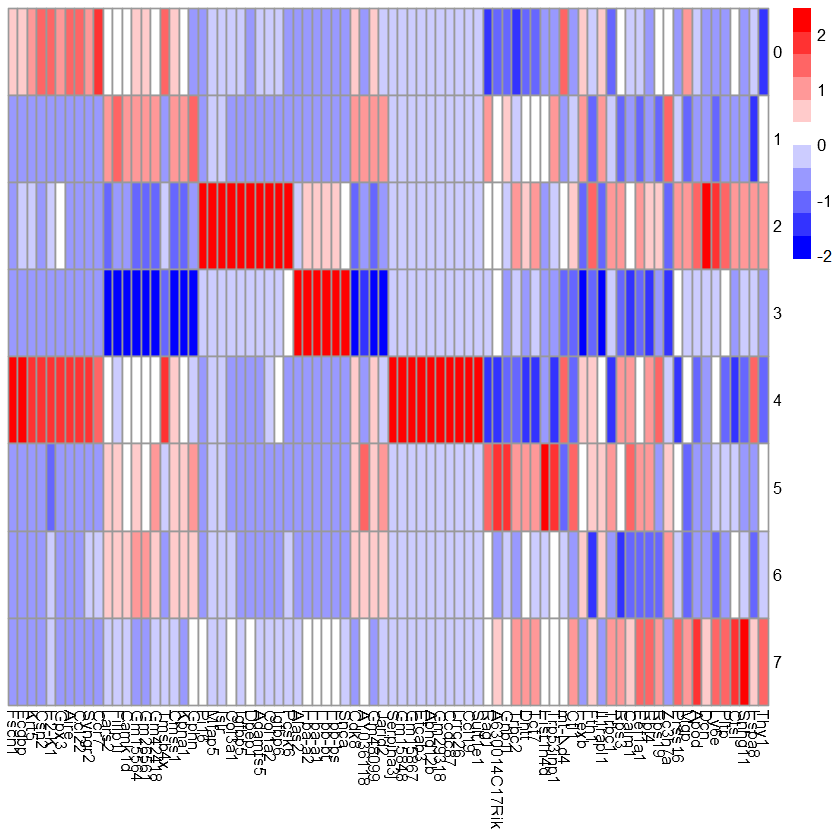

In [3]:
myplot <- function(
	a, ann, ann_color=NA, n.col=11, c_col=T, c_row=F, show_rownames=T, show_colnames=T, 
	breaks=seq(from=-max(abs(a)), to=max(abs(a)), len=n.col + 1), fontsize = 10
) {
	# print(a)
	pheatmap(
		a, color = colorRampPalette(c("blue", "white", "red"))(n.col), clustering_distance_rows = "correlation",  clustering_distance_cols = "correlation",  clustering_method = "complete",
		cluster_cols = c_col, cluster_rows = c_row, fontsize = fontsize
	)
}

top_gene_num = 10
feat_type = 'gene'
dat_ = read.csv(paste0("./res/", feat_type, "_dat_top=", top_gene_num, ".csv"), row.names=1)
dat_ = t(scale(t(dat_), center = TRUE, scale = TRUE))
dat_[dat_ > 4] = 4
dat_[dat_ < -4] = -4

colnames(dat_)=c("0","1","2","3","4","5","6","7")

s=rownames(dat_)
for(i in 1:length(s)){
  if(substr(s[i],1,15)=="mouse_rat_human"){
    s[i]=substr(s[i],17,nchar(s[i]))
  }
  if(substr(s[i],1,11)=="mouse_human"){
   s[i]=substr(s[i],13,nchar(s[i]))
  }
  if(substr(s[i],1,5)=="mouse"){
    s[i]=substr(s[i],7,nchar(s[i]))
  }
  if(substr(s[i],1,5)=="Mouse"){
    s[i]=substr(s[i],7,nchar(s[i]))
  }
  if(substr(s[i],1,5)=="Human"){
    s[i]=substr(s[i],7,nchar(s[i]))
  }
  if(substr(s[i],1,3)=="Rat"){
   s[i]=substr(s[i],5,nchar(s[i]))
  }  
}
rownames(dat_)=s
fontsize = 10
#pdf(paste0("./fig/fontsize=", fontsize, "_top=", top_gene_num, ".pdf"),width=11, height=3.7)
myplot(t(dat_), ann=NA, ann_color=NA, c_col=F, c_row=F, show_colnames=F, show_rownames=T, fontsize=fontsize)
dev.off()
tt=t(dat_)

## Perform Gene Set Enrichment Analysis
Use Cluster 1 as an example.

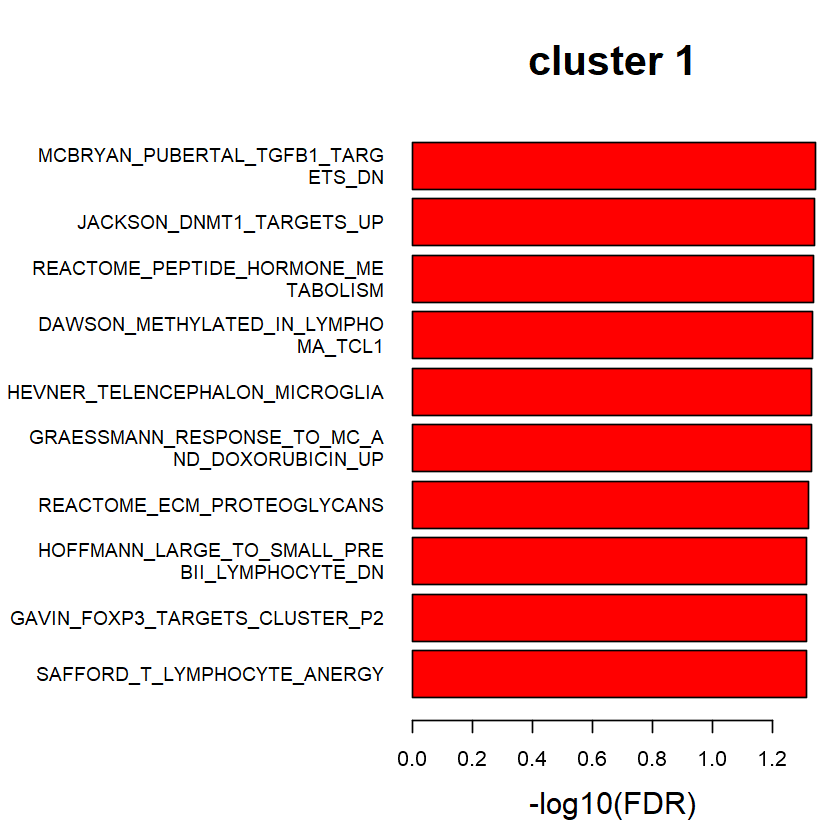

In [2]:
library(fgsea)
library(Seurat)
library (dplyr)
library(tibble)
library(GSA)
library(ggplot2)
library(stringr)
i = 1
colors <- c("red","orange","yellow", "green", "cyan", "blue","purple","deeppink")
gmt.file <- GSA::GSA.read.gmt("./data/m2.all.v2024.1.Mm.symbols.gmt")
de <- read.csv(paste0("Cluster_", as.character(i - 1), "_marker.csv"))

# sort genes according to logFC
colnames(de)[colnames(de) == "X"] <- "genes"
cluster0.genes <- de %>% arrange(desc(avg_log2FC)) %>% dplyr::select(genes,avg_log2FC)


ranks <- deframe(cluster0.genes)
pathways=gmt.file$genesets
names(pathways)=gmt.file$geneset.names

fgseaRes <- fgsea(pathways, ranks, minSize = 15, maxSize = 500)


half <- function(x) {
  n = 27
  string_length <- nchar(x)
  if(string_length < n + 5) {
    return(x)
  }
  if(string_length > 2 * n) {
    third_length=floor(string_length / 3)
    first_half <- substr(x, 1, n)
    if(substr(first_half, n, n) == "_") {
      first_half = substr(first_half, 1, n - 1)
    }
    second_half <- substr(x, n + 1, 2 * n - 1)
    if(substr(second_half, 1, 1) == "_") {
      second_half = substr(second_half, 2, n - 1)
    }
    if(substr(second_half, n - 1, n - 1) == "_") {
      second_half = substr(second_half, 1, n - 2)
    }
    #third_half <- substr(x, 80 + 1, string_length)
    return(paste(first_half, second_half, sep="\n"))
  }
  half_length <- floor(string_length / 2)
  
  first_half <- substr(x, 1, n)
  if(substr(first_half, n, n) == "_") {
    first_half = substr(first_half, 1, n - 1)
  }

  second_half <- substr(x, n + 1, string_length)
  if(substr(second_half, 1, 1) == "_") {
    second_half = substr(second_half, 2, n - 1)
  }
  if(substr(second_half, n, n) == "_") {
    second_half = substr(second_half, 1, n - 2)
  }
  return(paste(first_half, second_half, sep="\n"))
}
fgsea = fgseaRes %>% as_tibble() %>% arrange(desc(padj)) %>% filter(padj < 0.05)
fgsea$leadingEdge<-NULL

Fgsea = fgseaRes %>% as_tibble() %>% arrange(desc(padj)) %>% filter(padj < 0.05) %>% head(n= 10)
name = Fgsea$pathway
name = sapply(name,function(x) half(x))
#pdf(paste0("./res/f", i, ".pdf"))#,width=11, height=7
par(mar=c(5, 17, 5, 1), fig=c(0, 1, 0, 1))
barplot(-log10(Fgsea$padj), names=name, col=colors[i], horiz = TRUE, las=1, xlab="-log10(FDR)", main=paste0("cluster ",as.character(i)), cex.names=0.92, cex.main=2, cex.lab=1.5)
#dev.off()
